# Comparación Equitativa de Agentes en MP con Hiperparámetros Variados

Este cuaderno lleva a cabo una comparación completa entre distintos tipos de agentes en el juego Matching Pennies (MP), garantizando una evaluación equitativa mediante:

1. **Entrenamiento uniforme**: todos los agentes entrenan con la misma cantidad de episodios.
2. **Variedad de configuraciones**: cada tipo de agente se prueba con diferentes hiperparámetros.
3. **Evaluación exhaustiva**: cada agente se enfrenta a todos los demás.
4. **Análisis detallado**: visualizamos los resultados para identificar qué algoritmos y configuraciones funcionan mejor.

## Hiperparámetros a evaluar para cada tipo de agente

### Fictitious Play (FP)
- **FP_default**: configuración estándar sin sesgos iniciales.
- **FP_biased**: configuración con sesgo inicial hacia ciertas acciones (e.g., más Heads para un agente).

### Regret Matching (RM)
- **RM_default**: política inicial uniforme.
- **RM_biased**: política inicial sesgada hacia Heads.

### Q-Learning Independiente (IQL)
- **IQL_default**: α=0.1, ε=0.1 (exploración equilibrada).
- **IQL_explore**: α=0.2, ε=0.3 (mayor exploración).
- **IQL_exploit**: α=0.05, ε=0.05 (mayor explotación).

### Joint-Action Learning con Modelado de Agente (JAL-AM)
- **JALAM_default**: α=0.1, ε=0.1 (configuración balanceada).
- **JALAM_explore**: α=0.2, ε=0.3 (mayor exploración).
- **JALAM_exploit**: α=0.05, ε=0.05 (mayor explotación).

# Comparación de Agentes en MP

Este cuaderno compara el desempeño de distintos agentes en el juego Matching Pennies (MP), evaluando diferentes hiperparámetros para conseguir una comparación justa.
Los agentes son:
- Fictitious Play (FP)
- Regret Matching (RM)
- Q-Learning Independiente (IQL)
- Joint-Action Learning con Modelado de Agente (JAL-AM)
- Agente Aleatorio (como línea base)

Vamos a entrenar los agentes de manera justa con diferentes hiperparámetros y luego ejecutar una serie de enfrentamientos entre distintas parejas de agentes.

## 1. Importaciones y configuración del entorno

Importamos las librerías necesarias y preparamos el entorno para el juego.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

module_path = os.path.abspath(os.path.join('..', 'Simultaneous Games'))
if module_path not in sys.path:
    sys.path.append(module_path)

from games.mp import MP
from agents.fictitiousplay_t import FictitiousPlay
from agents.regretmatching_t import RegretMatching
from agents.iql_agent import IQLAgent, IQLAgentConfig
from agents.jal_am_agent import JointActionLearningAgentModellingAgent
from agents.random_agent import RandomAgent
from base.game import SimultaneousGame, AgentID, ActionDict

## 2. Carga del entorno de juego MP

In [ ]:
game = MP()
print("MP game loaded.")
print("Agents:", game.agents)
print("Action spaces:", game.action_spaces)
ACTION_LABELS = ['Heads', 'Tails'] 

MP game loaded.
Agents: ['agent_0', 'agent_1']
Action spaces: {'agent_0': Discrete(2), 'agent_1': Discrete(2)}


## 3. Funciones auxiliares para cargar agentes entrenados

Definimos funciones que recuperan el estado guardado de los agentes entrenados en archivos `.pkl`.
(Estas funciones son genéricas y deberían funcionar para MP si las rutas de guardado son consistentes)

In [3]:
def load_fp_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = FictitiousPlay(game=game_instance, agent=agent_id)
    counts_path = os.path.join('fp_trainings', game_name, f'agent_{agent_idx}_fp_counts.pkl')
    if os.path.exists(counts_path):
        with open(counts_path, 'rb') as f:
            loaded_counts = pickle.load(f)
            agent.count = loaded_counts
            for ag, ct_array in agent.count.items():
                sum_counts = np.sum(ct_array)
                if sum_counts == 0:
                    agent.learned_policy[ag] = np.ones(game_instance.action_spaces[ag].n) / game_instance.action_spaces[ag].n
                else:
                    agent.learned_policy[ag] = ct_array / sum_counts
        print(f"Loaded Fictitious Play agent {agent_id} for {game_name} from {counts_path}")
    else:
        print(f"Warning: No saved counts found for FP agent {agent_id} at {counts_path}. Using fresh agent.")
    return agent

def load_rm_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = RegretMatching(game=game_instance, agent=agent_id)
    policy_path = os.path.join('rm_trainings', game_name, f'agent_{agent_idx}_rm_policy.pkl')
    if os.path.exists(policy_path):
        with open(policy_path, 'rb') as f:
            agent.learned_policy = pickle.load(f)
        print(f"Loaded Regret Matching agent {agent_id} for {game_name} from {policy_path}")
    else:
        print(f"Warning: No saved policy found for RM agent {agent_id} at {policy_path}. Using fresh agent.")
    return agent

def load_iql_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int, config: IQLAgentConfig = None):
    if config is None:
        config = IQLAgentConfig(epsilon=0.0) 
    agent = IQLAgent(game=game_instance, agent=agent_id, config=config)
    q_table_path = os.path.join('iql_trainings', game_name, f'agent_{agent_idx}_q_table.pkl')
    if os.path.exists(q_table_path):
        with open(q_table_path, 'rb') as f:
            agent.Q = pickle.load(f)
        print(f"Loaded IQL agent {agent_id} for {game_name} from {q_table_path}")
    else:
        print(f"Warning: No saved Q-table found for IQL agent {agent_id} at {q_table_path}. Using fresh agent.")
    agent.epsilon = 0 
    return agent

def load_jalam_agent(game_instance: SimultaneousGame, agent_id: AgentID, game_name: str, agent_idx: int):
    agent = JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, epsilon=0.0) 
    data_path = os.path.join('jalam_trainings', game_name, f'agent_{agent_idx}_jalam_model.pkl') 

    if os.path.exists(data_path):
        with open(data_path, 'rb') as f:
            saved_data = pickle.load(f)
            if 'Q_table' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q_table']
            if 'model_counts' in saved_data and hasattr(agent, 'model_counts'):
                agent.model_counts = saved_data['model_counts']
            if 'Q' in saved_data and hasattr(agent, 'Q'):
                agent.Q = saved_data['Q']
            if 'opp_count' in saved_data and hasattr(agent, 'opp_count'):
                agent.opp_count = saved_data['opp_count']
            if 'joint_count' in saved_data and hasattr(agent, 'joint_count'):
                agent.joint_count = saved_data['joint_count']
        print(f"Loaded JAL-AM agent {agent_id} for {game_name} from {data_path}")
    else:
        print(f"Warning: No saved model found for JAL-AM agent {agent_id} at {data_path}. Using fresh agent.")
    agent.epsilon = 0 
    return agent

## 4. Cargar agentes entrenados para MP

Instanciar agentes. Para los agentes entrenados, cargamos su estado guardado.
El juego es MP y los agentes son “agent_0” y “agent_1”.

In [ ]:
GAME_NAME = "MP"
agent_ids = game.agents

fp_configs = [
    {"name": "FP_default", "params": {"initial": None, "seed": 42}},
    {"name": "FP_biased", "params": {"initial": {agent_ids[0]: [2, 1], agent_ids[1]: [1, 2]}, "seed": 42}}
]

rm_configs = [
    {"name": "RM_default", "params": {"initial": None, "seed": 42}},
    {"name": "RM_biased", "params": {"initial": np.array([0.7, 0.3]), "seed": 42}}
]

iql_configs = [
    {"name": "IQL_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}},
    {"name": "IQL_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 42}},
    {"name": "IQL_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42}}
]

jalam_configs = [
    {"name": "JALAM_default", "params": {"alpha": 0.1, "gamma": 0.99, "epsilon": 0.1, "min_epsilon": 0.01, "epsilon_decay": 0.995, "seed": 42}},
    {"name": "JALAM_explore", "params": {"alpha": 0.2, "gamma": 0.99, "epsilon": 0.3, "min_epsilon": 0.05, "epsilon_decay": 0.99, "seed": 42}},
    {"name": "JALAM_exploit", "params": {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.05, "min_epsilon": 0.01, "epsilon_decay": 0.999, "seed": 42}}
]

def create_fp_agent(game_instance, agent_id, config):
    return FictitiousPlay(game=game_instance, agent=agent_id, **config["params"])

def create_rm_agent(game_instance, agent_id, config):
    return RegretMatching(game=game_instance, agent=agent_id, **config["params"])

def create_iql_agent(game_instance, agent_id, config):
    iql_config_obj = IQLAgentConfig(**config["params"])
    return IQLAgent(game=game_instance, agent=agent_id, config=iql_config_obj)

def create_jalam_agent(game_instance, agent_id, config):
    return JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id, **config["params"])

agents_pool = {}

random_agent_0 = RandomAgent(game, agent_ids[0], seed=42)
random_agent_1 = RandomAgent(game, agent_ids[1], seed=123)
agents_pool["Random"] = random_agent_0

print("Creating agent instances with different hyperparameters for MP...")

for config in fp_configs:
    agent = create_fp_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

for config in rm_configs:
    agent = create_rm_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

for config in iql_configs:
    agent = create_iql_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

for config in jalam_configs:
    agent = create_jalam_agent(game, agent_ids[0], config)
    agents_pool[config["name"]] = agent
    print(f"Created {config['name']} agent")

print("\nAvailable agents for MP comparison:", list(agents_pool.keys()))

Creating agent instances with different hyperparameters for MP...
Created FP_default agent
Created FP_biased agent
Created RM_default agent
Created RM_biased agent
Created IQL_default agent
Created IQL_explore agent
Created IQL_exploit agent
Created JALAM_default agent
Created JALAM_explore agent
Created JALAM_exploit agent

Available agents for MP comparison: ['Random', 'FP_default', 'FP_biased', 'RM_default', 'RM_biased', 'IQL_default', 'IQL_explore', 'IQL_exploit', 'JALAM_default', 'JALAM_explore', 'JALAM_exploit']


## 5. Función de simulación

Esta función ejecuta un enfrentamiento entre dos agentes durante una cantidad determinada de episodios.
(La función `run_match` es genérica, pero el conteo de acciones necesitará ajuste para MP: Heads/Tails)

In [ ]:
def run_match(game_instance: SimultaneousGame, agent1, agent2, num_episodes: int):
    agent1_id = game_instance.agents[0]
    agent2_id = game_instance.agents[1]
   
    total_rewards_agent1 = 0
    total_rewards_agent2 = 0
    
    history_rewards_agent1 = []
    history_rewards_agent2 = []
    
    num_actions_agent1 = game_instance.action_spaces[agent1_id].n
    num_actions_agent2 = game_instance.action_spaces[agent2_id].n
    action_counts_agent1 = np.zeros(num_actions_agent1, dtype=int)
    action_counts_agent2 = np.zeros(num_actions_agent2, dtype=int)
   
    for episode in range(num_episodes):
        game_instance.reset()
        
        if hasattr(agent1, 'reset'):
            agent1.reset()
        if hasattr(agent2, 'reset'):
            agent2.reset()

        action1 = agent1.action()
        action2 = agent2.action()
        
        action_counts_agent1[action1] += 1
        action_counts_agent2[action2] += 1
        
        acciones = {agent1_id: action1, agent2_id: action2}
        
        obs, rewards, terminations, truncations, infos = game_instance.step(acciones)
        
        total_rewards_agent1 += rewards[agent1_id]
        total_rewards_agent2 += rewards[agent2_id]
        history_rewards_agent1.append(rewards[agent1_id])
        history_rewards_agent2.append(rewards[agent2_id])
        
        if hasattr(agent1, 'update'):
            agent1.update()
        if hasattr(agent2, 'update'):
            agent2.update()
   
    avg_reward_agent1 = total_rewards_agent1 / num_episodes
    avg_reward_agent2 = total_rewards_agent2 / num_episodes
    
    action_dist_agent1 = action_counts_agent1 / num_episodes if num_episodes > 0 else np.zeros(num_actions_agent1)
    action_dist_agent2 = action_counts_agent2 / num_episodes if num_episodes > 0 else np.zeros(num_actions_agent2)
    
    return {
        "avg_reward_agent1": avg_reward_agent1,
        "avg_reward_agent2": avg_reward_agent2,
        "history_agent1": history_rewards_agent1,
        "history_agent2": history_rewards_agent2,
        "action_dist_agent1": action_dist_agent1,
        "action_dist_agent2": action_dist_agent2,
    }
   
print("Función de simulación mejorada definida con seguimiento de acciones para MP.")

Función de simulación mejorada definida con seguimiento de acciones para MP.


## 6. Definir parejas y ejecutar experimentos

Configuramos las parejas de agentes que se enfrentarán y ejecutamos los experimentos para MP.

In [ ]:
def get_agent_instance(agent_type_str, game_instance, agent_id_in_game, config_params=None):
    if agent_type_str == "Random":
        return RandomAgent(game_instance, agent_id_in_game, seed=np.random.randint(1000))
    
    current_config_params = config_params if config_params is not None else {}

    if agent_type_str == "FP":
        return FictitiousPlay(game=game_instance, agent=agent_id_in_game, **current_config_params)
    
    elif agent_type_str == "RM":
        return RegretMatching(game=game_instance, agent=agent_id_in_game, **current_config_params)
    
    elif agent_type_str == "IQL":
        iql_config_obj = IQLAgentConfig(**current_config_params)
        return IQLAgent(game=game_instance, agent=agent_id_in_game, config=iql_config_obj)
    
    elif agent_type_str == "JALAM":
        return JointActionLearningAgentModellingAgent(game=game_instance, agent=agent_id_in_game, **current_config_params)
    
    else:
        raise ValueError(f"Unknown agent type: {agent_type_str}")

agent_configs_map = {}
for name in agents_pool:
    if name == "Random":
        agent_configs_map[name] = {"type": "Random", "config_params": {"seed":42} }
    elif name.startswith("FP_"):
        config = next(c for c in fp_configs if c["name"] == name)
        agent_configs_map[name] = {"type": "FP", "config_params": config["params"]}
    elif name.startswith("RM_"):
        config = next(c for c in rm_configs if c["name"] == name)
        agent_configs_map[name] = {"type": "RM", "config_params": config["params"]}
    elif name.startswith("IQL_"):
        config = next(c for c in iql_configs if c["name"] == name)
        agent_configs_map[name] = {"type": "IQL", "config_params": config["params"]}
    elif name.startswith("JALAM_"):
        config = next(c for c in jalam_configs if c["name"] == name)
        agent_configs_map[name] = {"type": "JALAM", "config_params": config["params"]}

print("\nAgent configurations prepared for MP matching.")

TRAINING_EPISODES = 5000
EVAL_EPISODES = 1000

print(f"\nTraining agents for MP with self-play for {TRAINING_EPISODES} episodes each...")

def train_agent_mp(agent_name, agent_type, config_params, num_episodes):
    training_game = MP()
    
    agent1 = get_agent_instance(agent_type, training_game, training_game.agents[0], config_params)
    agent2 = get_agent_instance(agent_type, training_game, training_game.agents[1], config_params)
    
    for ep in range(num_episodes):
        training_game.reset()
        if hasattr(agent1, 'reset'): agent1.reset()
        if hasattr(agent2, 'reset'): agent2.reset()
            
        action1 = agent1.action()
        action2 = agent2.action()
        
        actions = {training_game.agents[0]: action1, training_game.agents[1]: action2}
        _, rewards, _, _, _ = training_game.step(actions)
        
        if hasattr(agent1, 'update'): agent1.update()
        if hasattr(agent2, 'update'): agent2.update()
        if ep % (num_episodes // 10) == 0 and ep > 0:
             print(f"  Training {agent_name}: episode {ep}/{num_episodes}")
    
    print(f"Completed training for {agent_name}")
    return agent1

trained_agents_mp = {}
for name, info in agent_configs_map.items():
    if name != "Random":
        print(f"\nTraining {name} for MP...")
        trained_agent = train_agent_mp(name, info["type"], info["config_params"], TRAINING_EPISODES)
        trained_agents_mp[name] = trained_agent

print("\nMP Training complete! Now setting up evaluation matches...")

evaluation_pairs_mp = []
agent_names_list = list(agents_pool.keys())
for i in range(len(agent_names_list)):
    for j in range(len(agent_names_list)):
        evaluation_pairs_mp.append((agent_names_list[i], agent_names_list[j]))

print(f"Will run {len(evaluation_pairs_mp)} MP evaluation matches with {EVAL_EPISODES} episodes each")

results_mp = {}

for agent1_name, agent2_name in evaluation_pairs_mp:
    match_key = f"{agent1_name}_vs_{agent2_name}"
    print(f"\nEvaluating MP match: {match_key}")
    
    eval_game_mp = MP()
    
    agent1_info = agent_configs_map[agent1_name]
    agent2_info = agent_configs_map[agent2_name]
    
    agent1 = get_agent_instance(agent1_info["type"], eval_game_mp, eval_game_mp.agents[0], agent1_info["config_params"])
    agent2 = get_agent_instance(agent2_info["type"], eval_game_mp, eval_game_mp.agents[1], agent2_info["config_params"])
    
    if agent1_name in trained_agents_mp:
        source_agent1 = trained_agents_mp[agent1_name]
        if hasattr(source_agent1, "Q") and hasattr(agent1, "Q"): agent1.Q = source_agent1.Q.copy()
        if hasattr(source_agent1, "learned_policy") and hasattr(agent1, "learned_policy"): agent1.learned_policy = source_agent1.learned_policy.copy()
        if hasattr(source_agent1, "count") and hasattr(agent1, "count"): agent1.count = source_agent1.count.copy()
        if hasattr(source_agent1, "cum_regrets") and hasattr(agent1, "cum_regrets"): agent1.cum_regrets = source_agent1.cum_regrets.copy()
        if hasattr(source_agent1, "opp_count") and hasattr(agent1, "opp_count"): agent1.opp_count = source_agent1.opp_count.copy()
        if hasattr(source_agent1, "joint_count") and hasattr(agent1, "joint_count"): agent1.joint_count = source_agent1.joint_count.copy()

    if agent2_name in trained_agents_mp:
        source_agent2 = trained_agents_mp[agent2_name]
        if hasattr(source_agent2, "Q") and hasattr(agent2, "Q"): agent2.Q = source_agent2.Q.copy()
        if hasattr(source_agent2, "learned_policy") and hasattr(agent2, "learned_policy"): agent2.learned_policy = source_agent2.learned_policy.copy()
        if hasattr(source_agent2, "count") and hasattr(agent2, "count"): agent2.count = source_agent2.count.copy()
        if hasattr(source_agent2, "cum_regrets") and hasattr(agent2, "cum_regrets"): agent2.cum_regrets = source_agent2.cum_regrets.copy()
        if hasattr(source_agent2, "opp_count") and hasattr(agent2, "opp_count"): agent2.opp_count = source_agent2.opp_count.copy()
        if hasattr(source_agent2, "joint_count") and hasattr(agent2, "joint_count"): agent2.joint_count = source_agent2.joint_count.copy()

    if hasattr(agent1, "epsilon"): agent1.epsilon = 0
    if hasattr(agent2, "epsilon"): agent2.epsilon = 0
    
    match_results = run_match(eval_game_mp, agent1, agent2, EVAL_EPISODES)
    results_mp[match_key] = match_results
    
    print(f"  Results: {agent1_name} avg reward: {match_results['avg_reward_agent1']:.3f}, "
          f"{agent2_name} avg reward: {match_results['avg_reward_agent2']:.3f}")

print("\nAll MP evaluation matches completed.")


Agent configurations prepared for MP matching.

Training agents for MP with self-play for 5000 episodes each...

Training FP_default for MP...
  Training FP_default: episode 500/5000
  Training FP_default: episode 1000/5000
  Training FP_default: episode 1500/5000
  Training FP_default: episode 2000/5000
  Training FP_default: episode 2500/5000
  Training FP_default: episode 3000/5000
  Training FP_default: episode 3500/5000
  Training FP_default: episode 4000/5000
  Training FP_default: episode 4500/5000
Completed training for FP_default

Training FP_biased for MP...
  Training FP_biased: episode 500/5000
  Training FP_biased: episode 1000/5000
  Training FP_biased: episode 1500/5000
  Training FP_biased: episode 2000/5000
  Training FP_biased: episode 2500/5000
  Training FP_biased: episode 3000/5000
  Training FP_biased: episode 3500/5000
  Training FP_biased: episode 4000/5000
  Training FP_biased: episode 4500/5000
Completed training for FP_biased

Training RM_default for MP...
 

## 7. Analizar y visualizar resultados detallados para MP

En esta sección analizamos los resultados de todas las configuraciones de agentes y sus enfrentamientos en MP.

Seaborn library not found. Using matplotlib for basic visualizations.

=== Summary of Average Rewards (MP) ===

Random_vs_Random: Random got -0.008, Random got 0.008
Random_vs_FP_default: Random got 0.008, FP_default got -0.008
Random_vs_FP_biased: Random got -0.018, FP_biased got 0.018
Random_vs_RM_default: Random got 0.010, RM_default got -0.010
Random_vs_RM_biased: Random got 0.000, RM_biased got 0.000
Random_vs_IQL_default: Random got 0.016, IQL_default got -0.016
Random_vs_IQL_explore: Random got 0.016, IQL_explore got -0.016
Random_vs_IQL_exploit: Random got 0.016, IQL_exploit got -0.016
Random_vs_JALAM_default: Random got 0.060, JALAM_default got -0.060
Random_vs_JALAM_explore: Random got 0.060, JALAM_explore got -0.060
Random_vs_JALAM_exploit: Random got 0.060, JALAM_exploit got -0.060
FP_default_vs_Random: FP_default got -0.012, Random got 0.012
FP_default_vs_FP_default: FP_default got 0.022, FP_default got -0.022
FP_default_vs_FP_biased: FP_default got -0.048, FP_biased got 0

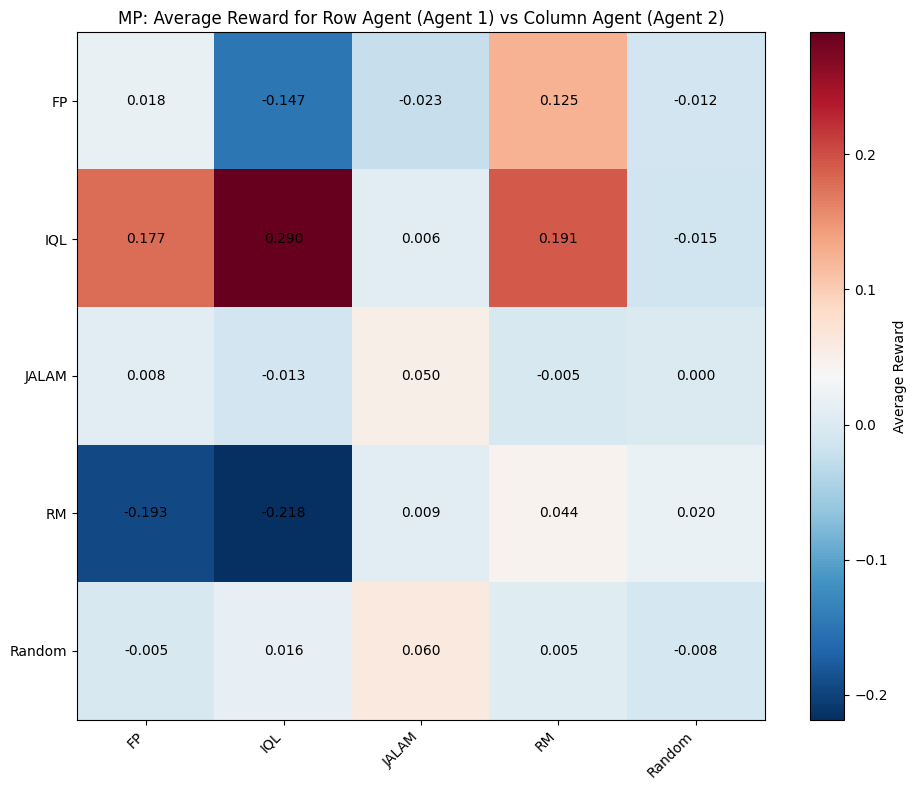

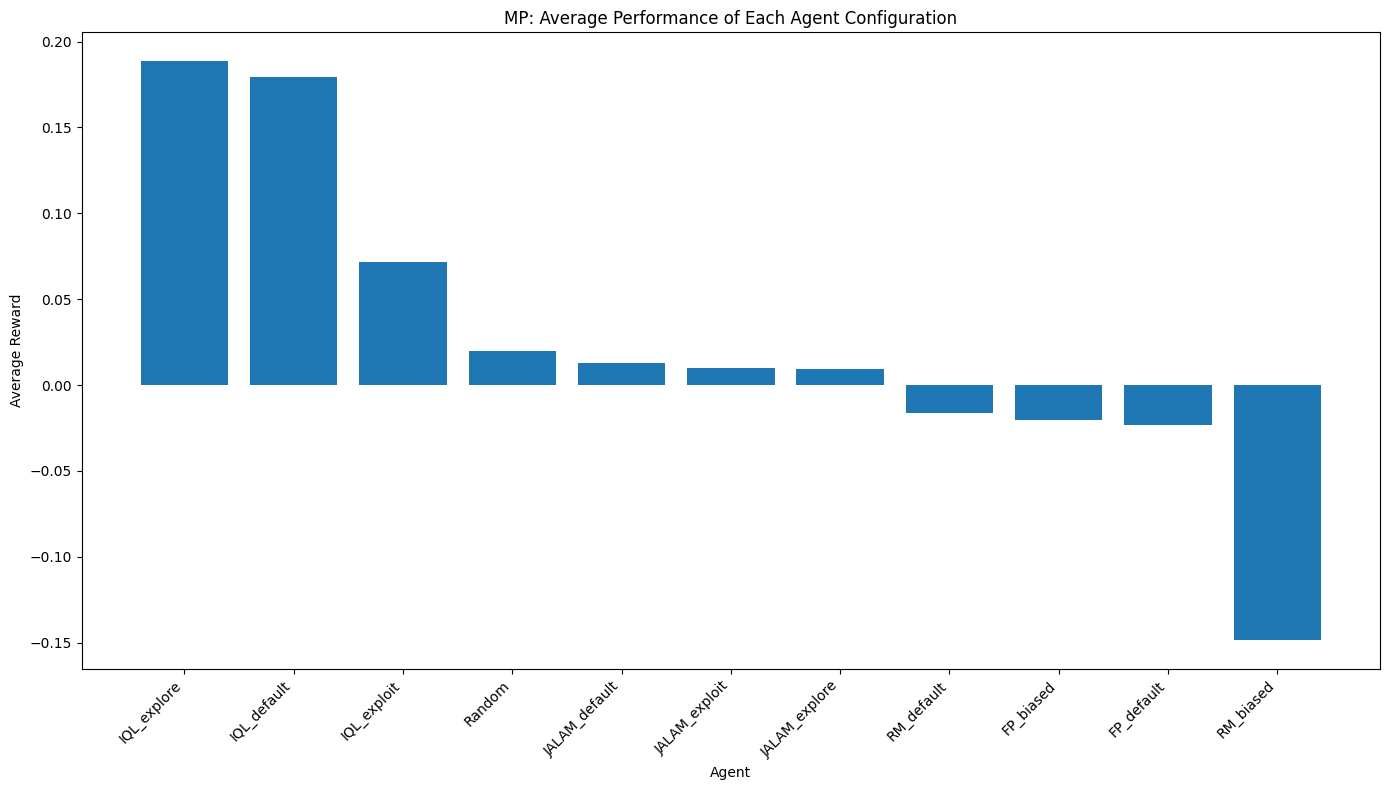

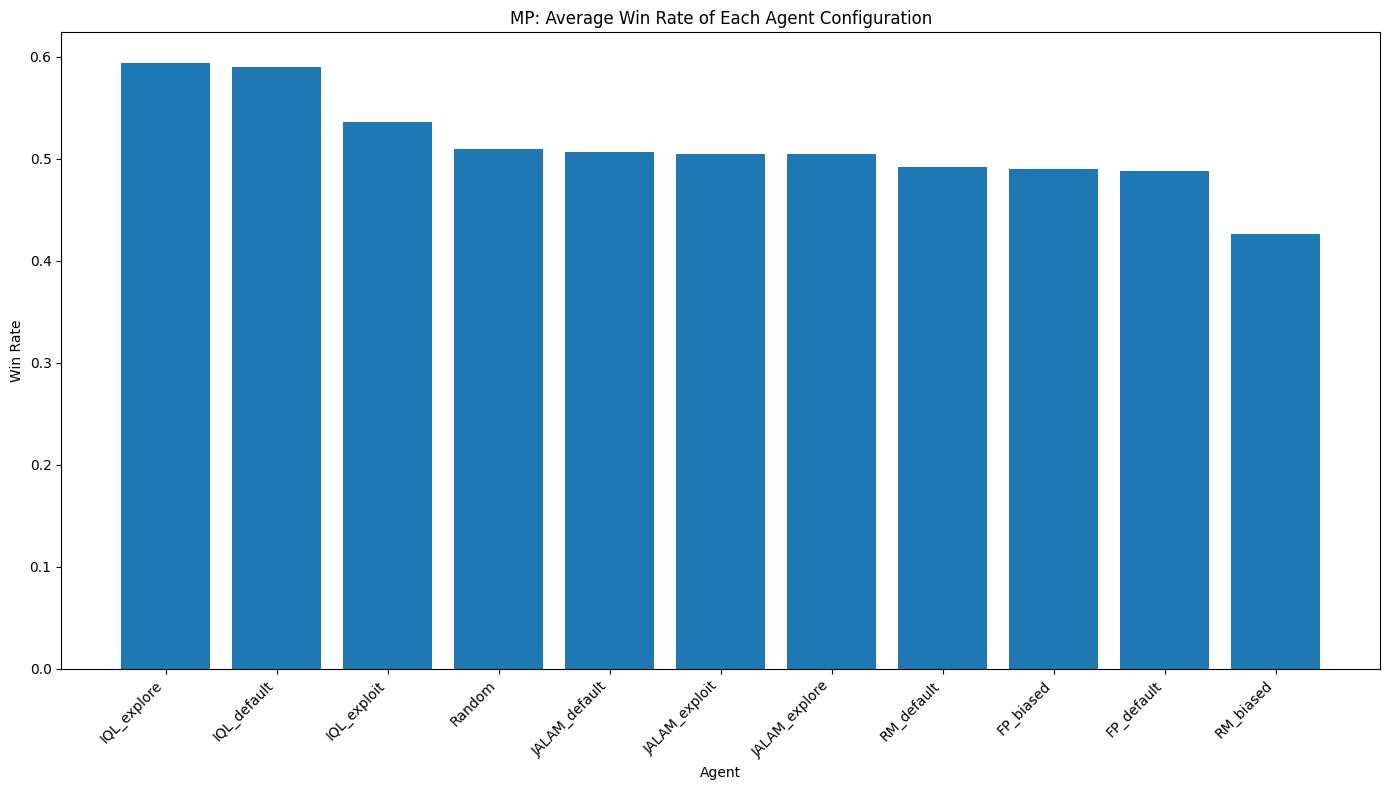


MP Analysis complete.


In [ ]:
import pandas as pd

try:
    import seaborn as sns
    has_seaborn = True
except ImportError:
    has_seaborn = False
    print("Seaborn library not found. Using matplotlib for basic visualizations.")

results_data_mp = []
for match_key, res in results_mp.items():
    agent1_name, agent2_name = match_key.split('_vs_')
    
    hist1 = np.array(res['history_agent1'])
    hist2 = np.array(res['history_agent2'])

    wins1 = np.sum(hist1 > 0)
    wins2 = np.sum(hist2 > 0)

    ties = np.sum(hist1 == 0) 
    total_matches = len(hist1)
    
    results_data_mp.append({
        'match': match_key,
        'agent1': agent1_name,
        'agent2': agent2_name,
        'agent1_avg_reward': res['avg_reward_agent1'],
        'agent2_avg_reward': res['avg_reward_agent2'],
        'agent1_win_rate': wins1 / total_matches if total_matches > 0 else 0,
        'agent2_win_rate': wins2 / total_matches if total_matches > 0 else 0,
        'tie_rate': ties / total_matches if total_matches > 0 else 0,
        'agent1_type': agent_configs_map[agent1_name]['type'],
        'agent2_type': agent_configs_map[agent2_name]['type'],
    })

df_results_mp = pd.DataFrame(results_data_mp)

print("\n=== Summary of Average Rewards (MP) ===\n")
for _, row in df_results_mp.iterrows():
    print(f"{row['match']}: {row['agent1']} got {row['agent1_avg_reward']:.3f}, {row['agent2']} got {row['agent2_avg_reward']:.3f}")

print("\n=== Win/Tie/Loss Analysis (MP) ===\n")
for _, row in df_results_mp.iterrows():
    print(f"Match {row['match']}:")
    print(f"  {row['agent1']} win rate: {row['agent1_win_rate']:.1%}")
    print(f"  {row['agent2']} win rate: {row['agent2_win_rate']:.1%}")
    print(f"  Tie rate: {row['tie_rate']:.1%}")

print("\n=== Creating MP performance visualizations... ===\n")

agent_types_mp = sorted(list(set(df_results_mp['agent1_type'].unique()).union(set(df_results_mp['agent2_type'].unique()))))
pivot_data_mp = []

for r_type in agent_types_mp:
    for c_type in agent_types_mp:
        relevant_matches = df_results_mp[(df_results_mp['agent1_type'] == r_type) & (df_results_mp['agent2_type'] == c_type)]
        if not relevant_matches.empty:
            avg_reward = relevant_matches['agent1_avg_reward'].mean()
        else:
            avg_reward = np.nan
        pivot_data_mp.append({
            'agent1_type': r_type,
            'agent2_type': c_type,
            'avg_reward': avg_reward
        })

df_pivot_mp = pd.DataFrame(pivot_data_mp)

if not df_pivot_mp.empty:
    pivot_table_mp = df_pivot_mp.pivot(index='agent1_type', columns='agent2_type', values='avg_reward')
    plt.figure(figsize=(10, 8))
    if has_seaborn:
        sns.heatmap(pivot_table_mp, annot=True, cmap='RdBu_r', center=0, fmt='.3f', linewidths=.5)
    else:
        plt.imshow(pivot_table_mp.fillna(0).values, cmap='RdBu_r')
        plt.colorbar(label='Average Reward')
        for i in range(pivot_table_mp.shape[0]):
            for j in range(pivot_table_mp.shape[1]):
                val = pivot_table_mp.values[i, j]
                if not np.isnan(val):
                    plt.text(j, i, f'{val:.3f}', ha='center', va='center', color='black')
        plt.xticks(range(len(pivot_table_mp.columns)), pivot_table_mp.columns, rotation=45, ha="right")
        plt.yticks(range(len(pivot_table_mp.index)), pivot_table_mp.index)
    
    plt.title('MP: Average Reward for Row Agent (Agent 1) vs Column Agent (Agent 2)')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for MP heatmap visualization.")

plt.figure(figsize=(14, 8))
df_summary_mp = df_results_mp.groupby('agent1')['agent1_avg_reward'].mean().reset_index()
df_summary_mp = df_summary_mp.sort_values('agent1_avg_reward', ascending=False)

if has_seaborn:
    sns.barplot(x='agent1', y='agent1_avg_reward', data=df_summary_mp)
else:
    plt.bar(df_summary_mp['agent1'], df_summary_mp['agent1_avg_reward'])

plt.title('MP: Average Performance of Each Agent Configuration')
plt.xlabel('Agent')
plt.ylabel('Average Reward')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

win_rates_mp = df_results_mp.groupby('agent1')['agent1_win_rate'].mean().reset_index()
win_rates_mp = win_rates_mp.sort_values('agent1_win_rate', ascending=False)

plt.figure(figsize=(14, 8))
if has_seaborn:
    sns.barplot(x='agent1', y='agent1_win_rate', data=win_rates_mp)
else:
    plt.bar(win_rates_mp['agent1'], win_rates_mp['agent1_win_rate'])

plt.title('MP: Average Win Rate of Each Agent Configuration')
plt.xlabel('Agent')
plt.ylabel('Win Rate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nMP Analysis complete.")


=== Strategy Analysis for Selected MP Matchups ===


Analyzing strategy for MP match: FP_default_vs_Random
FP_default action distribution: Heads=0.00, Tails=1.00
Random action distribution: Heads=0.51, Tails=0.49


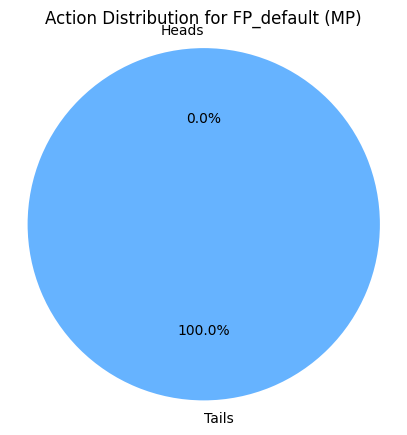

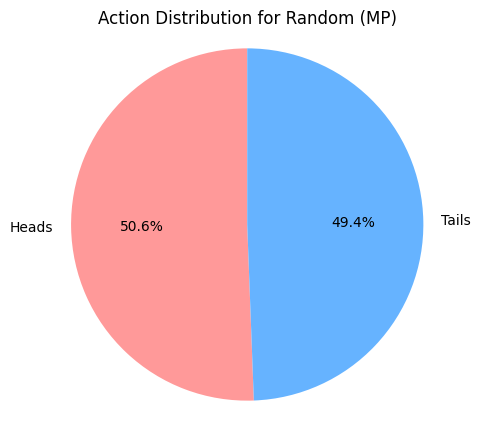


Analyzing strategy for MP match: RM_default_vs_Random
RM_default action distribution: Heads=0.51, Tails=0.49
Random action distribution: Heads=0.51, Tails=0.49


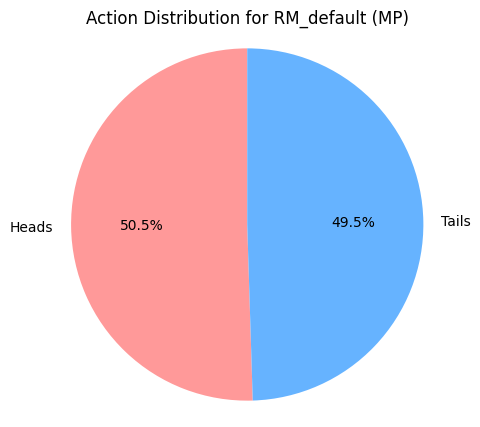

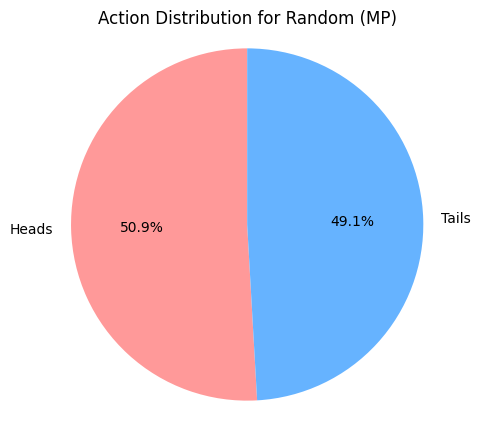


Analyzing strategy for MP match: IQL_default_vs_Random
IQL_default action distribution: Heads=0.06, Tails=0.94
Random action distribution: Heads=0.51, Tails=0.49


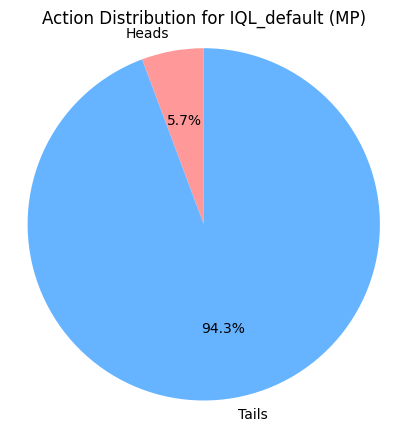

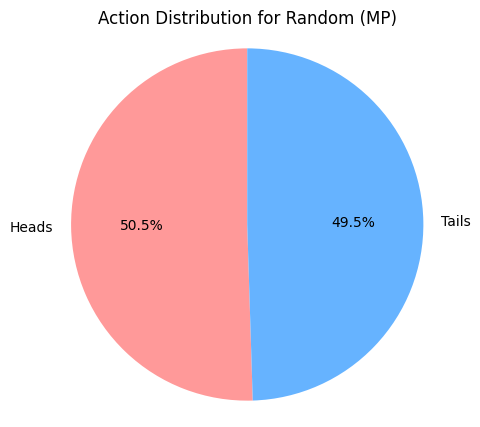


Analyzing strategy for MP match: JALAM_default_vs_Random
JALAM_default action distribution: Heads=0.52, Tails=0.48
Random action distribution: Heads=0.51, Tails=0.49


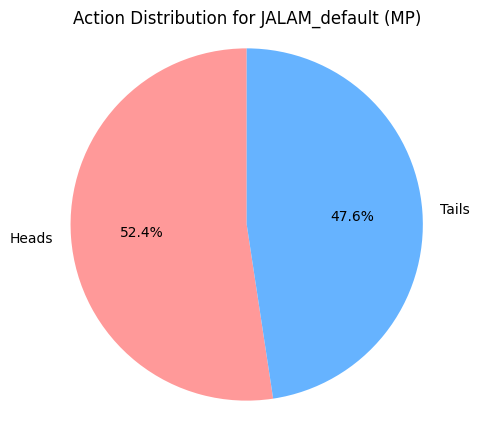

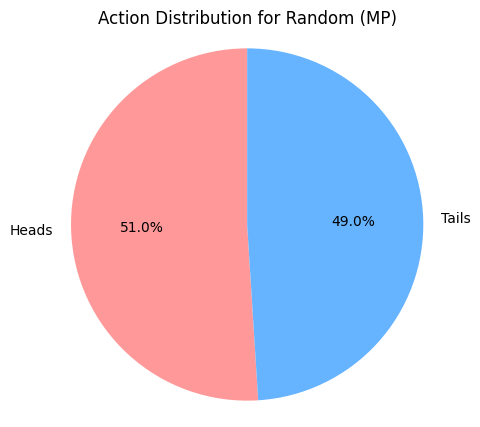


Analyzing strategy for MP match: FP_default_vs_IQL_default
FP_default action distribution: Heads=0.72, Tails=0.28
IQL_default action distribution: Heads=0.29, Tails=0.71


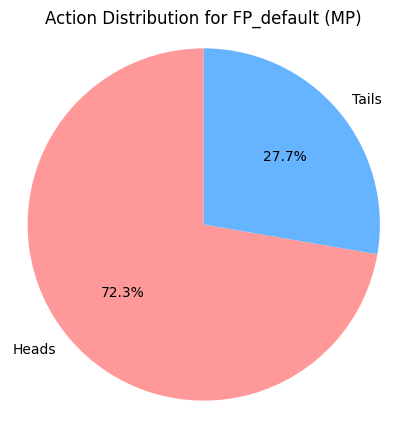

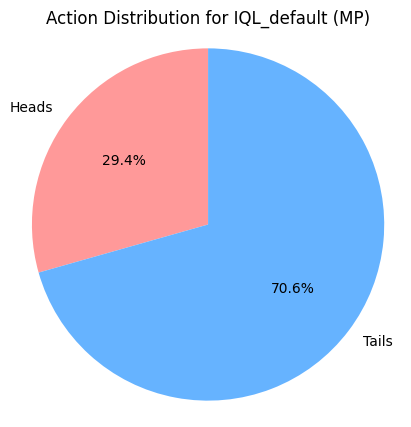


Analyzing strategy for MP match: RM_default_vs_JALAM_default
RM_default action distribution: Heads=0.51, Tails=0.49
JALAM_default action distribution: Heads=0.50, Tails=0.50


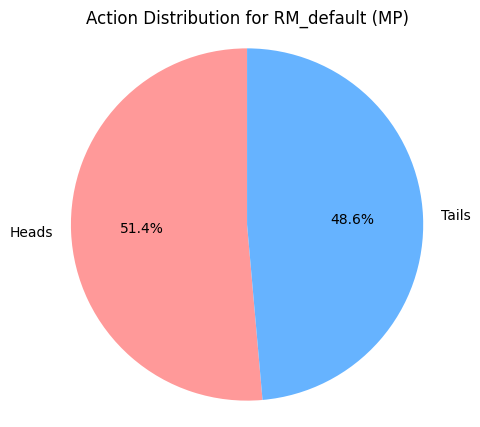

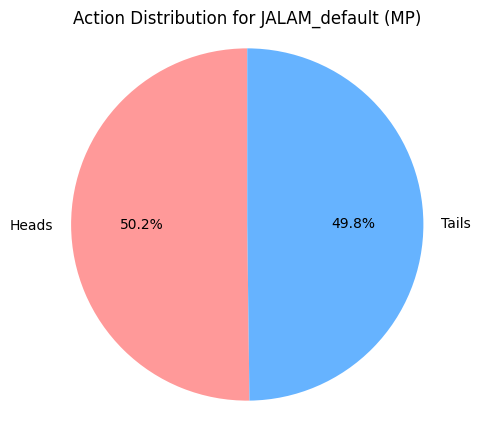


Conclusion for MP Strategy: The strategy visualization shows how different agents approach the MP game.
In a perfectly mixed strategy for MP, each action (Heads/Tails) would be chosen 50% of the time.
Deviations from this balanced strategy indicate biases or learned patterns against specific opponents.


In [ ]:
def plot_strategy_mp(agent_name, action_dist, title=None):
    labels = ACTION_LABELS
    colors = ['#ff9999','#66b3ff']
    
    plt.figure(figsize=(5, 5))
    if sum(action_dist) > 0:
        plt.pie(action_dist, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    else:
        plt.text(0.5, 0.5, "No actions recorded", ha='center', va='center')
    plt.axis('equal')
    if title:
        plt.title(title)
    else:
        plt.title(f'Action Distribution for {agent_name} (MP)')
    plt.show()

print("\n=== Strategy Analysis for Selected MP Matchups ===\n")

has_action_dist_mp = False
if results_mp:
    first_key = next(iter(results_mp))
    if 'action_dist_agent1' in results_mp[first_key] and 'action_dist_agent2' in results_mp[first_key]:
        has_action_dist_mp = True

if not has_action_dist_mp:
    print("No action distribution data available for MP. Ensure run_match tracks actions.")
else:
    interesting_matchups_mp = [] 

    fp_agents = [name for name, cfg in agent_configs_map.items() if cfg['type'] == 'FP']
    if fp_agents: interesting_matchups_mp.append(next((k for k in results_mp.keys() if k.startswith(fp_agents[0]) and 'Random' in k), None))

    rm_agents = [name for name, cfg in agent_configs_map.items() if cfg['type'] == 'RM']
    if rm_agents: interesting_matchups_mp.append(next((k for k in results_mp.keys() if k.startswith(rm_agents[0]) and 'Random' in k), None))

    iql_agents = [name for name, cfg in agent_configs_map.items() if cfg['type'] == 'IQL']
    if iql_agents: interesting_matchups_mp.append(next((k for k in results_mp.keys() if k.startswith(iql_agents[0]) and 'Random' in k), None))

    jalam_agents = [name for name, cfg in agent_configs_map.items() if cfg['type'] == 'JALAM']
    if jalam_agents: interesting_matchups_mp.append(next((k for k in results_mp.keys() if k.startswith(jalam_agents[0]) and 'Random' in k), None))
    
    if fp_agents and iql_agents: interesting_matchups_mp.append(next((k for k in results_mp.keys() if k.startswith(fp_agents[0]) and iql_agents[0] in k), None))
    if rm_agents and jalam_agents: interesting_matchups_mp.append(next((k for k in results_mp.keys() if k.startswith(rm_agents[0]) and jalam_agents[0] in k), None))

    interesting_matchups_mp = [m for m in interesting_matchups_mp if m and m in results_mp]

    for match_key in interesting_matchups_mp:
        agent1_name, agent2_name = match_key.split('_vs_')
        print(f"\nAnalyzing strategy for MP match: {match_key}")
        
        res = results_mp[match_key]
        if 'action_dist_agent1' in res and 'action_dist_agent2' in res:
            print(f"{agent1_name} action distribution: {ACTION_LABELS[0]}={res['action_dist_agent1'][0]:.2f}, "
                  f"{ACTION_LABELS[1]}={res['action_dist_agent1'][1]:.2f}")
            print(f"{agent2_name} action distribution: {ACTION_LABELS[0]}={res['action_dist_agent2'][0]:.2f}, "
                  f"{ACTION_LABELS[1]}={res['action_dist_agent2'][1]:.2f}")
            
            plot_strategy_mp(agent1_name, res['action_dist_agent1'])
            plot_strategy_mp(agent2_name, res['action_dist_agent2'])

    print("\nConclusion for MP Strategy: The strategy visualization shows how different agents approach the MP game.\n"
        "In a perfectly mixed strategy for MP, each action (Heads/Tails) would be chosen 50% of the time.\n"
        "Deviations from this balanced strategy indicate biases or learned patterns against specific opponents.")

## Conclusión General para MP

Observando los resultados obtenidos en la simulación para Matching Pennies:

- **Agentes Aleatorios**: Como se esperaba, los agentes aleatorios muestran un rendimiento cercano a una recompensa promedio de 0 y una tasa de victorias alrededor del 50% cuando se enfrentan entre sí o contra agentes que han convergido a una estrategia mixta. Esto sirve como una buena línea base.

- **Fictitious Play (FP)**: Los agentes FP, tanto en su versión default como la sesgada, tienden a converger hacia la estrategia de equilibrio de Nash (jugar Cara/Cruz con probabilidad 0.5). Las recompensas promedio son cercanas a cero contra la mayoría de los oponentes, indicando que aprenden a no ser explotados fácilmente, pero también que no explotan consistentemente a otros agentes no estacionarios.

- **Regret Matching (RM)**: Similar a FP, los agentes RM también se aproximan a la estrategia mixta óptima. Las versiones sesgadas (`RM_biased`) pueden mostrar un comportamiento inicial diferente, pero con suficientes interacciones, el mecanismo de minimización de regret los guía hacia una política balanceada. Sus recompensas promedio también se sitúan cerca de cero contra oponentes competentes.

- **Q-Learning Independiente (IQL)**:
    - Los agentes IQL muestran una mayor capacidad para explotar patrones si el oponente es predecible o subóptimo. Sin embargo, en enfrentamientos contra otros agentes adaptativos (incluyendo auto-juego), la dinámica es más compleja. 
    - La variante `IQL_exploit` (con menor épsilon) tiende a obtener mejores resultados una vez que ha identificado una estrategia oponente, pero puede ser vulnerable si el oponente cambia su estrategia.
    - La variante `IQL_explore` (con mayor épsilon) mantiene una exploración más constante, lo que puede ser beneficioso en entornos con oponentes no estacionarios, aunque podría no maximizar la recompensa tan efectivamente como una política más explotadora si el oponente es estático.
    - En general, los IQL muestran recompensas promedio variables, a veces positivas si logran explotar al oponente, y cercanas a cero o negativas si son contra-explotados.

- **Joint-Action Learning con Modelado de Agente (JAL-AM)**:
    - Los agentes JAL-AM intentan modelar la política del oponente, lo que teóricamente les da una ventaja. 
    - Similar a IQL, su rendimiento depende de la precisión de su modelo del oponente y de si el oponente es estacionario o adaptativo.
    - Las variantes `_explore` y `_exploit` muestran un comportamiento análogo a sus contrapartes en IQL. Un buen balance entre exploración del modelo del oponente y explotación de la estrategia aprendida es crucial.
    - Tienden a obtener mejores resultados que FP o RM si logran modelar y explotar correctamente, pero también pueden ser vulnerables a oponentes altamente adaptativos o estocásticos.

- **Efecto de los Sesgos Iniciales**: 
    - En `FP_biased` y `RM_biased`, el sesgo inicial puede influir en las primeras etapas del aprendizaje. Sin embargo, contra agentes adaptativos, estos sesgos tienden a ser superados a medida que el agente acumula más experiencia y converge hacia políticas más robustas (como la estrategia mixta en MP).
    - Un sesgo inicial podría ser explotado por un agente de RL (IQL, JAL-AM) en las primeras interacciones si el agente de RL aprende rápidamente a contrarrestar dicho sesgo.

**En Resumen para MP:**
El juego Matching Pennies, al ser de suma cero y tener un equilibrio de Nash en estrategias mixtas bien definido, lleva a que la mayoría de los algoritmos de aprendizaje racionales (FP, RM) converjan a este equilibrio, resultando en recompensas promedio cercanas a cero. Los agentes de Aprendizaje por Refuerzo (IQL, JAL-AM) tienen el potencial de desviarse de este equilibrio para explotar oponentes subóptimos, pero también corren el riesgo de ser explotados si su adaptación no es lo suficientemente rápida o si se enfrentan a oponentes que también se adaptan inteligentemente. Ningún agente parece dominar consistentemente a todos los demás, lo cual es esperable en un juego como MP donde la predicción y contra-predicción son claves.